In [1]:
import numpy as np
from numpy import radians
from lib.cartpolesystem import CartPoleSystem
from lib.cartpoleenv import CartPoleEnv
from lib.colors import Colors
from lib.direct_collocation import DirectCollocation
from lib.controllers import LQR
from time import perf_counter
from matplotlib import pyplot as plt

In [2]:
dt = 0.005
g = 9.81

n = 1
system_noise = 0.00000001 * np.diag(np.ones(2+2*n))

system = CartPoleSystem(
    (0.0, 0.5, 0.005, -0.8, 0.8, Colors.red),
    (0.2, 8.7e-5, 8.7e-5, 0.02, 0.05, 24.0, Colors.black),
    [
        (0, 0.1, 0.2, 0.001, Colors.green),
    ],
    g,
    dt,
    "rk4",
    "nonlinear",
    system_noise
)

env = CartPoleEnv(system, dt, g)
env.action_space

Box(-24.0, 24.0, (1, 1), float64)

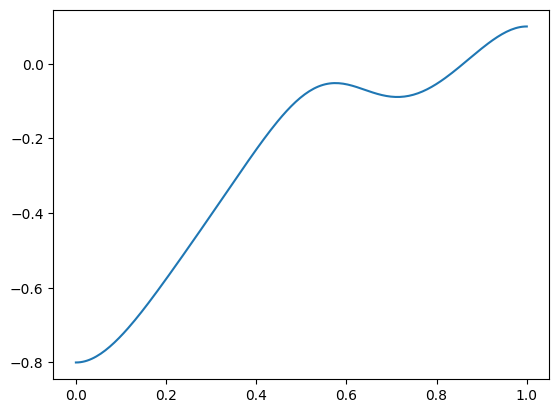

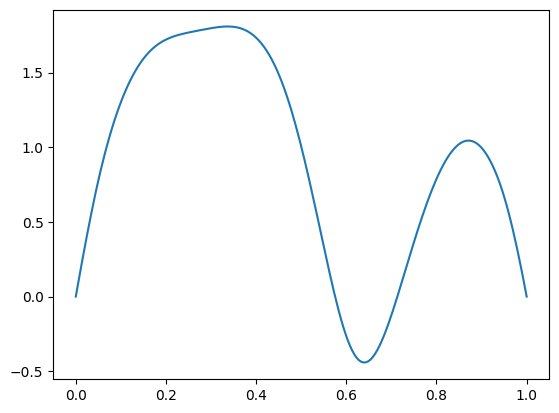

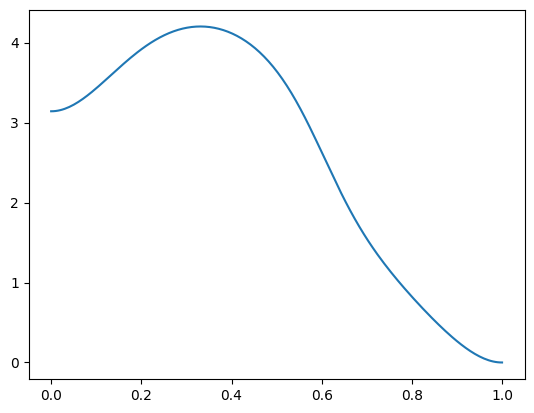

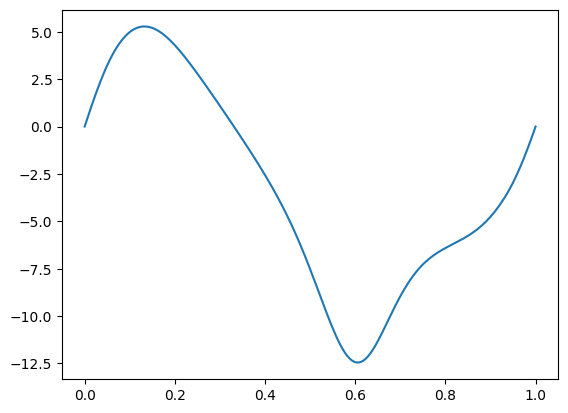

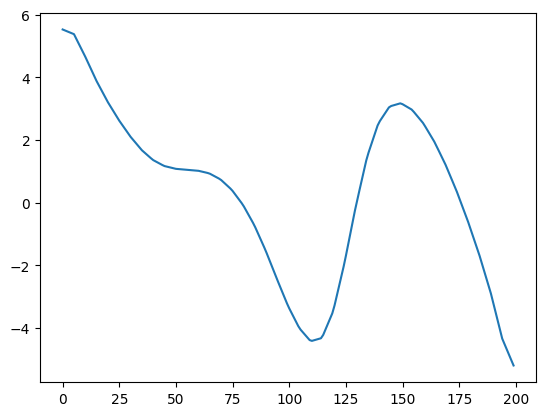

In [3]:
direct_collocation = DirectCollocation(
    41, 
    system.differentiate, 
    system.state_lower_bound.shape[0],
    system.state_upper_bound.shape[0],
    system.state_lower_bound,
    system.state_upper_bound,
    system.control_lower_bound,
    system.control_upper_bound,
    0.001
)

x0 = np.vstack([-0.8, 0, radians(180), 0])

r = np.vstack(
    [0.1, 0, 0, 0]
)

end_time = 1
N = int(end_time/dt)

last_update = perf_counter()

state, control = direct_collocation.make_controller(end_time, N, x0, r)

time = np.linspace(0, end_time, N)

for s in state:
    plt.plot(time, s)
    plt.show()
plt.plot(control[0])
plt.show()


In [4]:
linearization_x0 = np.zeros((2+2*n, 1))
linearization_u0 = np.vstack([0])

# A, B = system.linearize_old()
A, B = system.linearize(linearization_x0, linearization_u0)

C = np.eye(2+2*n)
D = np.zeros((2+2*n, 1))

ct_dt = dt

sys = LQR(A, B, C, D, dt=ct_dt)

Q = np.eye(2+2*n)
R = np.diag([0.01])

sys.calculate_K_lqr(Q, R)
sys.calculate_K_r()

c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\lib\controllers.py:31: RuntimeWarning: divide by zero encountered in divide
  K_r = np.true_divide(1, self.D + self.C @ np.linalg.inv(-self.A + self.B @ self.K) @ self.B)
c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\lib\controllers.py:36: RuntimeWarning: divide by zero encountered in divide
  K_r_d = np.true_divide(1, self.D + self.C @ np.linalg.inv(np.eye(self.A_d.shape[0]) - self.A_d + self.B_d @ self.K_d) @ self.B_d)


In [14]:
last_update = perf_counter()

obs, _ = env.reset(x0)

time_longer = 10
N_longer = int(time_longer/dt)

for i in range(N_longer):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()
    
    u = sys.feedback_d(obs, r)

    if i < N:
        u = np.vstack([control[0][i]])

    max_Ia = 100
    max_Va_from_Ia = system.Ra * max_Ia + system.K*obs[1]/system.r
    min_Va_from_Ia = -max_Va_from_Ia

    if u[0] > min(system.max_Va, max_Va_from_Ia):
        u[0] = min(system.max_Va, max_Va_from_Ia)
    elif u[0] < max(-system.max_Va, min_Va_from_Ia):
        u[0] = max(-system.max_Va, min_Va_from_Ia)

    obs, reward, done, msg, _ = env.step(u)
    env.render()
env.close()

AttributeError: 'NoneType' object has no attribute 'fill'